In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table #, QTable, hstack, vstack
import astropy.units as u
import astropy.coordinates as coord
from astropy.io import fits
from astropy.constants import G
#from astropy.coordinates import frame_transform_graph
#from astropy.coordinates.matrix_utilities import matrix_transpose

import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from gala.dynamics.nbody import DirectNBody
#import galstreams

from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy import interpolate

#from scipy.interpolate import InterpolatedUnivariateSpline

import pickle
import emcee
from multiprocessing import Pool
import corner


ham = gp.Hamiltonian(gp.MilkyWayPotential())
ham_bovy = gp.Hamiltonian(gp.BovyMWPotential2014())
ham_heavy = gp.Hamiltonian(gp.MilkyWayPotential(nucleus=dict(m=0), halo=dict(c=0.95, m=7e11), bulge=dict(m=4e9), disk=dict(m=5.5e10)))

coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()


In [2]:
%matplotlib inline
plt.style.use('notebook')

In [3]:
nskip = 100
t = Table(fits.getdata('../data/GSE_DM_{:04d}.fits.gz'.format(nskip)))

In [4]:
c = coord.Galactocentric(x=t['X_gal']*u.kpc, y=t['Y_gal']*u.kpc, z=t['Z_gal']*u.kpc, 
                         v_x=t['Vx_gal']*u.km/u.s, v_y=t['Vy_gal']*u.km/u.s, v_z=t['Vz_gal']*u.km/u.s)

In [139]:
np.random.seed(138)

N = 1000
rmax = 100
pos = (np.random.rand(3,N)*2*rmax - rmax) * u.kpc
vel = np.zeros((3,N)) * u.km/u.s
cx = coord.Galactocentric(x=pos[0], y=pos[1], z=pos[2], v_x=vel[0], v_y=vel[1], v_z=vel[2])
wx = gd.PhaseSpacePosition(cx.cartesian)

c_arr = np.array([c.x.value, c.y.value, c.z.value]).T
cx_arr = np.array([cx.x.value, cx.y.value, cx.z.value]).T

In [140]:
dist = cdist(c_arr, cx_arr) * u.kpc
dist_inv = dist**-1

mdm = 1e4*u.Msun * nskip
phi = (-G*mdm * np.sum(dist_inv, axis=0)).to(u.kpc**2 * u.Myr**-2)

In [141]:
phi_err = 0.01 * np.abs(np.median(phi))

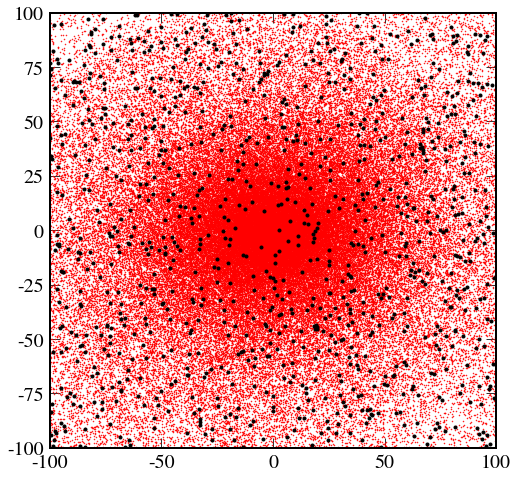

In [142]:
plt.plot(c.x, c.z, 'r.', ms=1)
plt.plot(cx.x, cx.z, 'k.')

plt.xlim(-rmax,rmax)
plt.ylim(-rmax,rmax);

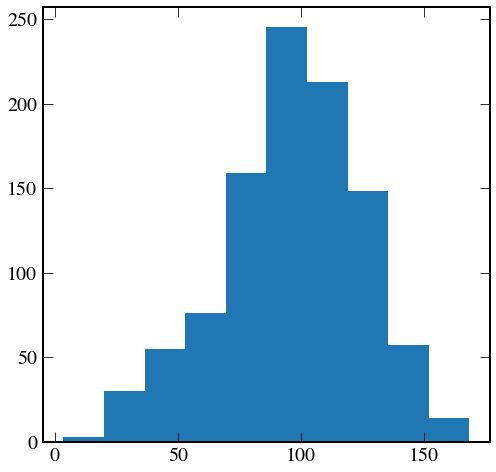

In [144]:
# cx.spherical.distance.min()
plt.hist(cx.spherical.distance.value);
# plt.hist(pos[0].value);
# plt.hist(pos[1].value);
# plt.hist(pos[2].value);
# plt.hist(cx.spherical.distance.value);
# plt.hist(cx.spherical.distance.value);

In [145]:
np.sum(cx.spherical.distance<10*u.kpc)

1

In [146]:
print(np.percentile(phi_err, [0.05,0.5,0.95]))

[6.28031097e-05 6.28031097e-05 6.28031097e-05] kpc2 / Myr2


In [168]:
def lnlike(x, wx, phi, phi_err):
    """Likelihood for a spherical NFW potential"""
    
    if (x[0]<10) | (x[0]>12) | (x[1]<0) | (x[1]>50):
        return -np.inf
    
    epot = gp.NFWPotential(m=10**x[0], r_s=x[1], units=galactic).energy(wx).to(u.kpc**2*u.Myr**-2).value
    
    chi = -0.5 * np.nansum(((epot - phi)/phi_err)**2)
    
    return chi

def lnlike_triax(x, wx, phi, phi_err):
    """Likelihood for a triaxial NFW potential"""
    
    if ((x[0]<10) | (x[0]>12) | (x[1]<0) | (x[1]>50) | (x[2]<1.) | (x[3]>x[2]) | (x[3]<1.) | 
        (x[4]>180) | (x[4]<-180) | (x[5]>90) | (x[5]<-90) | (x[6]>90) | (x[6]<-90)):
        return -np.inf
    
    epot = gp.NFWPotential(m=10**x[0], r_s=x[1], a=x[2], b=x[3], c=1., units=galactic, 
                           R=R.from_euler('xyz', (x[4], x[5], x[6]), degrees=True)).energy(wx).to(u.kpc**2*u.Myr**-2).value
    
    chi = -0.5 * np.nansum(((epot - phi)/phi_err)**2)
    
    return chi

In [148]:
lnlike([10.58,2.7], wx, phi.value, phi_err.value)

-149318.333857418

In [149]:
lnlike_triax([10.58,2.7, 1., 1., 0., 0., 0.], wx, phi.value, phi_err.value)

-149318.333857418

### spherical halo

In [150]:
nth = 3
seed = 5736
nwalkers = 64
nsteps = 512
        
pool = Pool(nth)
np.random.seed(seed)

p0s = [np.log10(5e10), 16]
p0 = emcee.utils.sample_ball(p0s, [1e-3, 1e-3], nwalkers)
p0 = np.abs(p0)

In [151]:
sampler = emcee.EnsembleSampler(nwalkers, p0.shape[1], log_prob_fn=lnlike, pool=pool, 
                                args=(wx, phi.value, phi_err.value))
_ = sampler.run_mcmc(p0, nsteps)

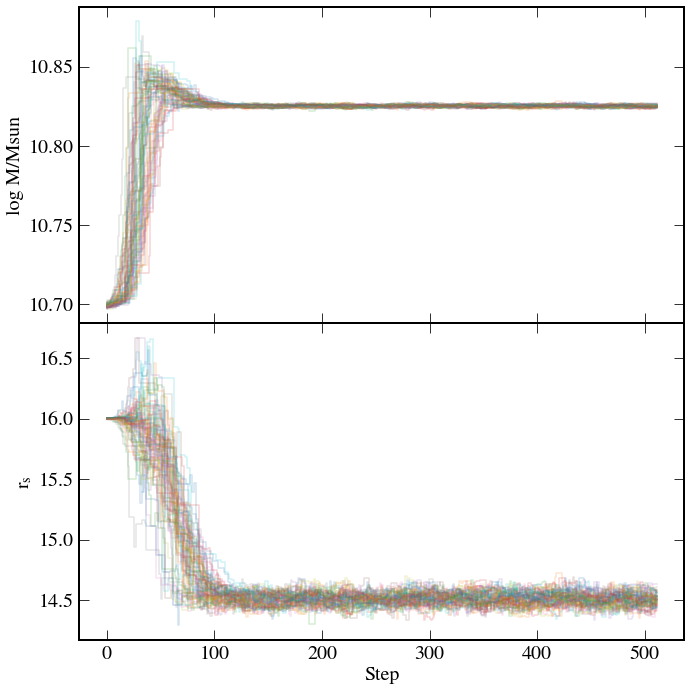

In [152]:
names = [r'log M/Msun', r'$r_s$']
    
fig, ax = plt.subplots(sampler.ndim, 1, figsize=(10,10), sharex=True, squeeze=False)

for k in range(sampler.ndim):
    for walker in sampler.chain[..., k]:
        ax[k][0].plot(walker, marker='', drawstyle='steps-mid', alpha=0.2)
    ax[k][0].set_ylabel(names[k])

plt.sca(ax[sampler.ndim-1][0])
plt.xlabel('Step')

plt.tight_layout(h_pad=0)

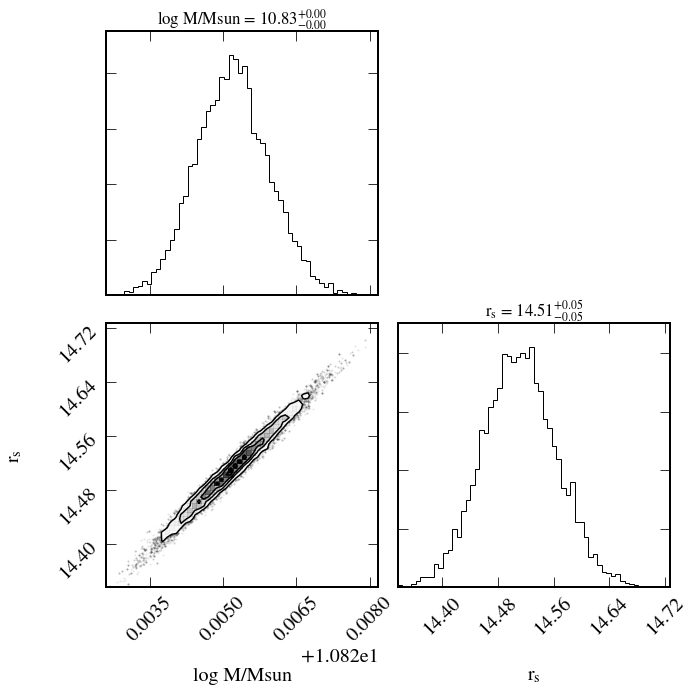

In [153]:
chain = sampler.get_chain(flat=True, discard=256)
bins = 60

fig, ax = plt.subplots(sampler.ndim, sampler.ndim, figsize=(10,10))
corner.corner(chain, bins=bins, labels=names, show_titles=True, title_fmt='.2f', 
              title_kwargs=dict(fontsize='small'), fig=fig)

plt.tight_layout(h_pad=0.1,w_pad=0.1)

In [160]:
'{:.3g}'.format(10**np.median(chain, axis=0)[0])

'6.69e+10'

### triaxial halo

In [169]:
nth = 3
seed = 194
nwalkers = 64
nsteps = 1024
        
pool = Pool(nth)
np.random.seed(seed)

p0s = [np.log10(5e10), 16, 1.1, 1.1, 90., 45., -45.]
p0 = emcee.utils.sample_ball(p0s, [1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3], nwalkers)
p0 = np.abs(p0)

In [170]:
sampler_triax = emcee.EnsembleSampler(nwalkers, p0.shape[1], log_prob_fn=lnlike_triax, pool=pool, 
                                args=(wx, phi.value, phi_err.value))
_ = sampler_triax.run_mcmc(p0, nsteps)

/usr/lib/python3.6/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


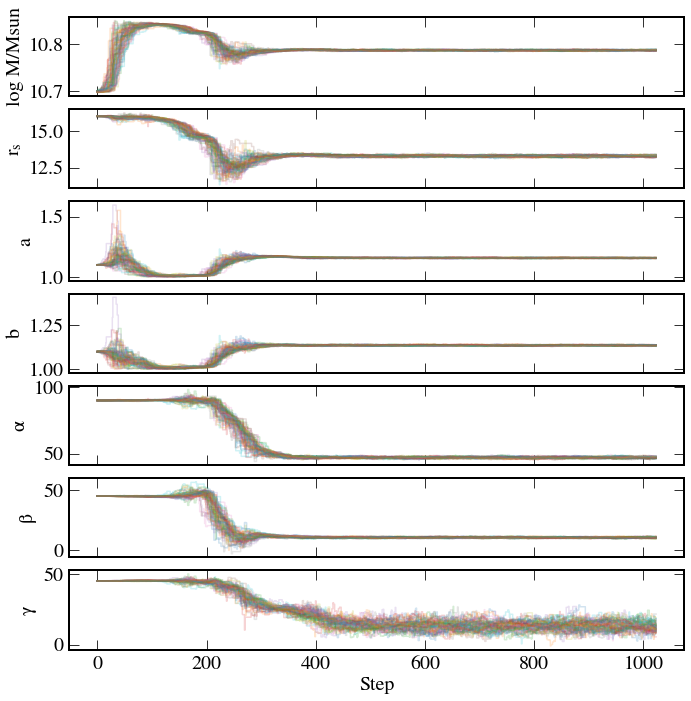

In [171]:
names = [r'log M/Msun', r'$r_s$', r'a', r'b', r'$\alpha$', r'$\beta$', r'$\gamma$']
    
fig, ax = plt.subplots(sampler_triax.ndim, 1, figsize=(10,10), sharex=True, squeeze=False)

for k in range(sampler_triax.ndim):
    for walker in sampler_triax.chain[..., k]:
        ax[k][0].plot(walker, marker='', drawstyle='steps-mid', alpha=0.2)
    ax[k][0].set_ylabel(names[k])

plt.sca(ax[sampler_triax.ndim-1][0])
plt.xlabel('Step')

plt.tight_layout(h_pad=0)

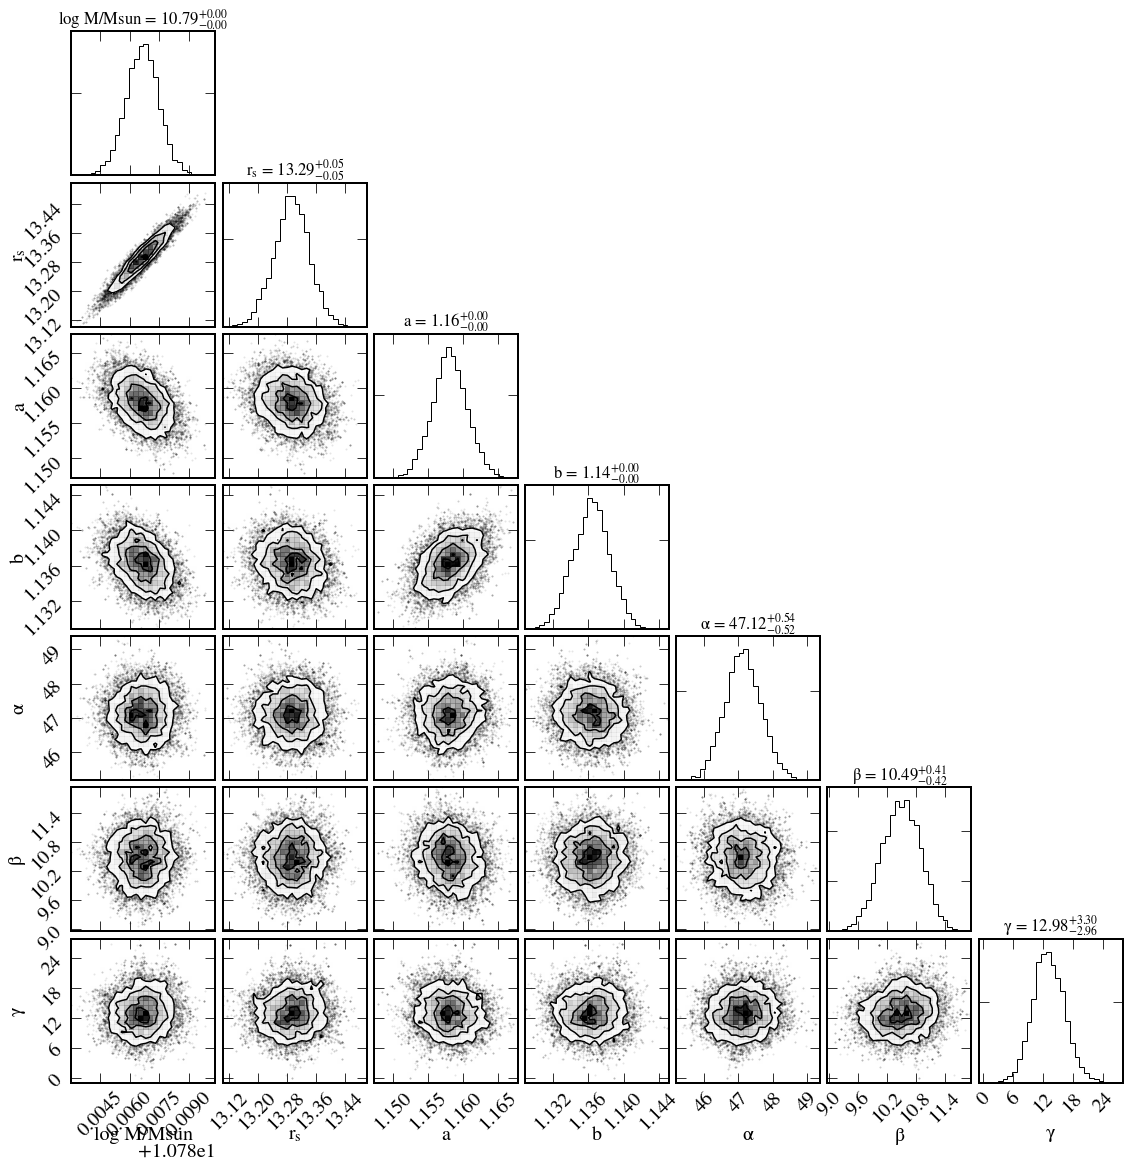

In [176]:
chain = sampler_triax.get_chain(flat=True, discard=600)
bins = 30

corner.corner(chain, bins=bins, labels=names, show_titles=True, title_fmt='.2f', 
              title_kwargs=dict(fontsize='small'));

plt.savefig('../plots/gse_dm_corner.png')

In [173]:
'{:.3g}'.format(10**np.median(chain, axis=0)[0])

'6.12e+10'

In [174]:
mgse = 10**np.median(chain, axis=0)[0]
mmw = 5.4e11

In [175]:
mgse/mmw

0.11330109062186276